In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
from scipy.stats import linregress as lin
from scipy.optimize import curve_fit
from scipy.signal import correlate
from datetime import datetime, timedelta
import re

from netCDF4 import Dataset

In [2]:
N = np.size(glob.glob("./dataGt/JPL_mscn*.csv", recursive=True))
M = np.shape(np.genfromtxt('JPL_mscn017.csv', delimiter=',', skip_header=15))[0]
t_30days = 30 * 24 * 3600.0

In [3]:
print(N, M)

31 163


In [4]:
file_n = sorted(glob.glob("./dataGt/JPL_mscn*.csv", recursive=True))
file_ids = np.zeros(len(file_n), dtype=np.int)
area_mscn = np.ones(len(file_n))

data = np.empty((N, M, 2))
for i, fn in enumerate(file_n):
    file = np.genfromtxt(fn, delimiter=',', skip_header=15)
    #print(file.shape,i)
    area_mscn[i] = np.genfromtxt(fn, delimiter=',', skip_header=6, skip_footer=170)[1]
    data[i] = file
    file_ids[i] = int(re.search("JPL_mscn(.+?)csv", fn).group(1)[:-1])

In [5]:
#data[0,:,1] * 1e-2 * area_mscn[0] * 1e6 * 1000 * 1e-12

In [6]:
# Detrend
trends = np.zeros((N, 7))
def fit_f(t, a0, a1, a2, a3, a4, b0, b1):
    lintr = a0 + a1 * t + a2 * t * t
    seasonal = a3 * np.cos(2.0 * np.pi / 365.25 * t + b0)
    halfyear = a4 * np.cos(4.0 * np.pi / 365.25 * t + b1)
    return lintr + seasonal + halfyear

for i in range(N):
    popt, pcov = curve_fit(fit_f, data[i,:,0], data[i,:,1])
    trends[i] = popt

def detrend(data, t, trend):
    return data - trend[0] - trend[1] * t - trend[2] * t ** 2 - trend[3] * np.cos(2.0 * np.pi / 365.25 * t + trend[5]) - trend[4] * np.cos(4.0 * np.pi / 365.25 * t + trend[6])
    
ddata = np.empty((N, M))
for i in range(N):
    ddata[i] = detrend(data[i,:,1], data[i,:,0], trends[i])
    
def resample_mascons(mascon_time, mascon_data, dt):
    """Resample mascon data on a given time scale to a linear time scale.
    
    Keyword arguments:
    mascon_time -- the mascon time scale in seconds
    mascon_data -- the mascon data associated with mascon_time
    dt -- the fixed sampling between min(mascon_time) and max(mascon_time) to use
    """
    
    t_min = np.min(mascon_time)
    t_max = np.max(mascon_time)
    t_range = np.arange(t_min, t_max, dt)
    ndata = np.empty((mascon_data.shape[0], t_range.size))
    for mi in range(ndata.shape[0]):
        ndata[mi,:] = np.interp(t_range, mascon_time, mascon_data[mi,:])
    return t_range, ndata
    
# Three point smoother with Weighted average
ddata_n = 2.0 * ddata.T + np.vstack((ddata.T[0], ddata.T[:-1])) + np.vstack((ddata.T[1:], ddata.T[-1]))
ddata = ddata_n.T / 4.0

# Resample mascons with sample width
# dt = 30 days 
# First convert time stamps to seconds
grace_t = data[0,:,0] * 86400 
grace_t, ddata = resample_mascons(grace_t, ddata, t_30days)

#tims = np.array([datetime(2002, 1, 1) + timedelta(days=int(t)) for t in data[data_num-1][:,0]])

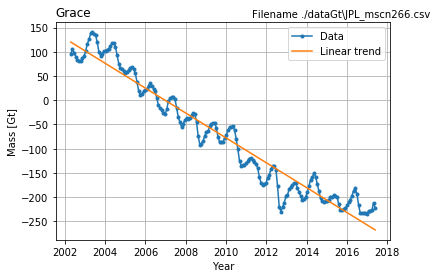

In [7]:
data_num = -1

#xlist = data[data_num-1][:,0] * 86400.0
#ylist = data[data_num-1][:,1]
xlist, ylist = resample_mascons(data[0,:,0] * 86400, data[:,:,1], t_30days)
xlist = xlist / (86400.0 * 365.25)
ylist = ylist[data_num-1]

trend = lin(xlist,ylist)

f, ax = plt.subplots()
ax.plot(xlist + 2002, ylist,'.-',label = 'Data')
ax.plot(xlist + 2002, xlist * trend[0] + trend[1],label = 'Linear trend')
ax.set_xlabel('Year')
ax.set_ylabel('Mass [Gt]')
plt.title('Grace', loc='left')
plt.legend()
ax.grid()
ax.text(0.58, 0.9, "Filename %s" % (file_n[data_num-1]), transform=f.transFigure)
f.savefig("./Pictures/timeseries_%i.png" % file_ids[data_num-1], dpi=300)
plt.show()

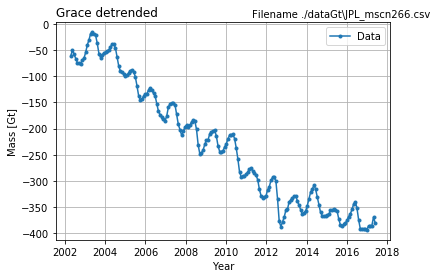

In [8]:
data_num = -1

#xlist = 2002 + data[data_num-1][:,0]/365.25
#tims = np.array([datetime(2002, 1, 1) + timedelta(days=int(t)) for t in data[data_num-1][:,0]])
#ylist = data[data_num-1][:,1]

xlist, ylist = resample_mascons(data[0,:,0] * 86400,  data[:,:,1], t_30days)
xlist = xlist / (86400. * 365.25)

detrended = detrend(ylist[data_num-1], xlist, trends[data_num-1])

f, ax = plt.subplots()
ax.plot(xlist + 2002,detrended,'.-',label = 'Data')
ax.set_xlabel('Year')
ax.set_ylabel('Mass [Gt]')
plt.title('Grace detrended', loc='left')
plt.legend()
ax.grid()
ax.text(0.58, 0.9, "Filename %s" % (file_n[data_num-1]), transform=f.transFigure)
f.savefig("./Pictures/timeseries_detrended_%i.png" % file_ids[data_num-1], dpi=300)
plt.show()

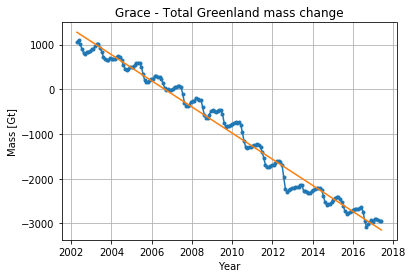

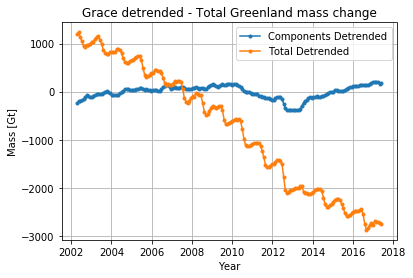

In [9]:
#xlist = 2002 + data[0][:,0]/365.25
#ylist = np.sum(data, axis = 0)[:,1]

xlist, ylist = resample_mascons(data[0,:,0] * 86400.0, data[:,:,1], t_30days)
xlist = xlist / (86400.0 * 365.25) + 2002
ylist = ylist.sum(axis=0)

total_trend = curve_fit(fit_f, (xlist - 2002) * 365.25, ylist)[0]
total_detrended = detrend(ylist, xlist, total_trend)
trend = lin(xlist, ylist)

plt.plot(xlist,ylist,'.-',label = 'Data')
plt.plot(xlist,xlist * trend[0] + trend[1],label = 'Linear trend')
plt.title('Grace - Total Greenland mass change')
plt.xlabel('Year')
plt.ylabel('Mass [Gt]')
plt.grid()
plt.savefig("./Pictures/timeseries_total", dpi=300)
plt.show()

plt.plot(xlist,ddata.sum(axis=0),'.-',label = 'Components Detrended')
plt.plot(xlist, total_detrended,'.-',label = 'Total Detrended')

plt.title('Grace detrended - Total Greenland mass change')
plt.xlabel('Year')
plt.ylabel('Mass [Gt]')
plt.grid()
plt.legend()
plt.savefig("./Pictures/timeseries_detrended_total", dpi=300)
plt.show()

In [10]:
vel_av = total_trend[1]
acc_av = total_trend[2]
total_time = (xlist[-1] - xlist[0]) * 365.25
print('The average speed is ' + str(np.round(vel_av,decimals=2)) + ' Gt/day.')
print('The average acceleration is ' + str(np.round(acc_av,decimals=6)) + ' Gt/day^2.')
print('The fraction of acceration of the velocity over the total time period is ' + str(np.round(100*acc_av/vel_av*total_time, decimals = 1)) + '%.')

The average speed is -0.68 Gt/day.
The average acceleration is -2.2e-05 Gt/day^2.
The fraction of acceration of the velocity over the total time period is 17.7%.


In [192]:
def seasons(timeseries, dataseries, ttype = 'y', stype ='all'): # timeseries is 1D, dataseries is 2D (timeseries, mascons)
    assert timeseries.size == dataseries.shape[1]
    if ttype == 'y': # years from 2002
        test = timeseries
    elif ttype == 's': # seconds from 2002
        test = timeseries / 365.25 / 86400
    timesize = np.shape(dataseries)[0]
    newsize = np.shape(dataseries)[1]//6
    newdata = np.zeros((timesize,newsize))
    newtime = np.linspace(0,newsize/2,newsize)
    for j in range(timesize):                   
        for i in range(newsize):
            cond1 = test<(0.5*(i+1)+0.25)
            cond2 = test>(0.5*i+0.25)
            cond = cond1 * cond2
            factor = max(1,np.sum(cond))
            newdata[j,i] = np.sum(dataseries[j]*cond)/factor
    newtime += 2002.5
    summertime = newtime[::2]
    wintertime = newtime[1::2]
    summerdata = newdata[:,::2]
    winterdata = newdata[:,1::2]
    if stype == 'all':
        return newtime, newdata
    if stype == 'sum':
        return summertime, summerdata
    if stype == 'win':
        return wintertime, winterdata

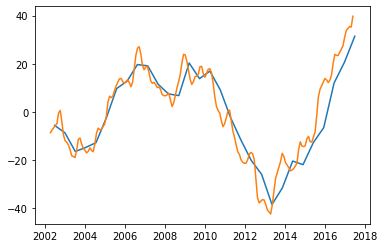

In [196]:
ps = seasons(xlist-2002, ddata)

mas_num = 20
plt.plot(ps[0],ps[1][mas_num])
plt.plot(xlist,ddata[mas_num])
plt.show()

In [ ]:
newsize = np.shape(ddata)[1]//6
newdata = np.zeros((np.shape(ddata)[0],newsize))
test = xlist-2002
newtime = np.linspace(0,newsize/2,newsize)

for j in range(np.shape(ddata)[0]):                   
    for i in range(newsize):
        cond1 = test<(0.5*(i+1)+0.25)
        cond2 = test>(0.5*i+0.25)
        cond = cond1 * cond2
        factor = max(1,np.sum(cond))
        newdata[j,i] = np.sum(ddata[j]*cond)/factor
summertime = newtime[::2]
wintertime = newtime[1::2]
summerdata = newdata[:,::2]
winterdata = newdata[:,1::2]

#plt.plot(2002.5+newtime,newdata[0])
plt.plot(2002.5+summertime,summerdata[0])
#plt.plot(2002.5+wintertime,winterdata[0])
plt.plot(xlist,ddata[0])
plt.show()

In [11]:
#F = data[:,:,1].T
F = ddata.T
FT = np.copy(F.T)
for i in range(FT.shape[0]):
    FT[i] -= FT[i].mean()
F = np.copy(FT.T)
C = np.dot(FT, F)
evals, evecs = np.linalg.eig(C)
PCA = np.dot(F, evecs[:])

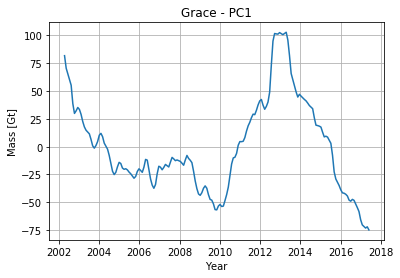

In [12]:
PCA_num = 1

plt.plot(xlist, PCA[:,PCA_num-1])
plt.xlabel('Year')
plt.ylabel('Mass [Gt]')
plt.title('Grace - PC' + str(PCA_num))
plt.grid()
plt.savefig("./Pictures/PC%i_total" %PCA_num, dpi=300)
plt.show()

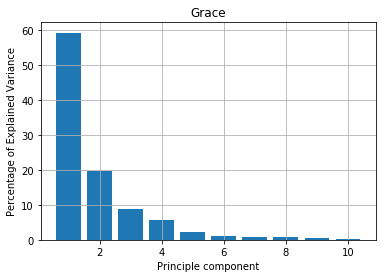

In [13]:
pca_max = 10
bars = evals / evals.sum()*100
plt.bar(x=range(1,pca_max+1), height=bars[:pca_max])
plt.xlabel('Principle component')
plt.ylabel('Percentage of Explained Variance')
plt.title('Grace')
plt.grid()
plt.savefig("./Pictures/PC_explained_total", dpi=300)
plt.show()

In [14]:
R_earth = 6371*10**3
A_earth = 4*np.pi*R_earth**2
N_c = 4551
teta = np.arange(-87,90,3)
teta = 2*np.pi/360*teta

In [15]:
def dellam(teta):
    return(4*np.pi/(np.cos(teta)*N_c* 3/360*2*np.pi))

In [16]:
lamda = np.zeros((teta.size, int(2.0 * np.pi // dellam(0))))
for i in range(teta.size):
    for j in range(lamda.shape[1]):
        lamda[i,j] = (j) * dellam(teta[i])
        if lamda[i,j] >= 2*np.pi:
            lamda[i,j] = np.nan

In [17]:
# testcell
lon = np.zeros(lamda.shape)
for i in range(lamda.shape[0]):
    if 2*np.pi-np.max(lamda[i,:]) < 0.5*lamda[i,1]:
        lon[i,:] = 360/(2*np.pi)*lamda[i,:]*2*np.pi/np.nanmax(lamda[i])
    else:
        siz = np.size(lamda[i,:])-np.isnan(lamda[i,:]).sum()
        lon[i,:] = (siz-1)/siz * 360/(2*np.pi)*lamda[i,:]*2*np.pi/np.nanmax(lamda[i])
        if siz < np.size(lamda[i,:]):
            lon[i,siz] = 360

lat = 360/(2*np.pi)*teta-1.5
#lon = 360/(2*np.pi)*lamda

In [18]:
def rebin_data(data, lats, irr_lons, true_color=True, lat_bounds=None, lon_bounds=None):
    rl_sz = irr_lons[0].size
    new_sz = 721
    lonspace = np.linspace(0,360,new_sz)
    fit = np.zeros((lat.size, new_sz))
    mask = np.full((lat.size, new_sz), False)
    rlons = None
    
    for k in range(irr_lons.shape[0]):
        sz = np.sum(np.logical_not(np.isnan(irr_lons[k])))
        al = np.zeros(rl_sz)
        ml = np.full(rl_sz, True)
        rlons = irr_lons[k] if sz == irr_lons[k].size else rlons
        if k == 1:
            al[sz-3] = data[0] if true_color else 0.0
            al[sz-2] = data[1] if true_color else 1.0

            ml[sz-3] = False
            ml[sz-2] = False
        if k == 2:
            al[sz-5] = data[2] if true_color else 1.0
            al[sz-4] = data[3] if true_color else 0.0
            al[sz-3] = data[4] if true_color else 1.0
            al[sz-2] = data[5] if true_color else 0.0

            ml[sz-5] = False
            ml[sz-4] = False
            ml[sz-3] = False
            ml[sz-2] = False
        if k == 3:
            al[sz-6] = data[6] if true_color else 0.0
            al[sz-5] = data[7] if true_color else 1.0
            al[sz-4] = data[8] if true_color else 0.0
            al[sz-3] = data[9] if true_color else 1.0

            ml[sz-6] = False
            ml[sz-5] = False
            ml[sz-4] = False
            ml[sz-3] = False
        if k == 4:
            al[sz-7] = data[10] if true_color else 1.0
            al[sz-6] = data[11] if true_color else 0.0
            al[sz-5] = data[12] if true_color else 1.0
            al[sz-4] = data[13] if true_color else 0.0
            al[sz-3] = data[14] if true_color else 1.0

            ml[sz-7] = False
            ml[sz-6] = False
            ml[sz-5] = False
            ml[sz-4] = False
            ml[sz-3] = False
        if k == 5:
            al[sz-7] = data[15] if true_color else 1.0
            al[sz-6] = data[16] if true_color else 0.0
            al[sz-5] = data[17] if true_color else 1.0
            al[sz-4] = data[18] if true_color else 0.0

            ml[sz-7] = False
            ml[sz-6] = False
            ml[sz-5] = False
            ml[sz-4] = False
        if k == 6:
            al[sz-8] = data[19] if true_color else 0.0
            al[sz-7] = data[20] if true_color else 1.0
            al[sz-6] = data[21] if true_color else 0.0
            al[sz-5] = data[22] if true_color else 1.0
            al[sz-4] = data[23] if true_color else 0.0

            ml[sz-8] = False
            ml[sz-7] = False
            ml[sz-6] = False
            ml[sz-5] = False
            ml[sz-4] = False
        if k == 7:
            al[sz-9] = data[24] if true_color else 1.0
            al[sz-8] = data[25] if true_color else 0.0
            al[sz-7] = data[26] if true_color else 1.0
            al[sz-6] = data[27] if true_color else 0.0

            ml[sz-9] = False
            ml[sz-8] = False
            ml[sz-7] = False
            ml[sz-6] = False
        if k == 8:
            al[sz-9] = data[28] if true_color else 1.0
            al[sz-8] = data[29] if true_color else 0.0

            ml[sz-9] = False
            ml[sz-8] = False
        if k == 9:
            al[sz-9] = data[30] if true_color else 0.0
            ml[sz-9] = False
        #fit = np.zeros(lon[29].size)
        j = 0
        for i in range(fit.shape[1]):
            if lonspace[i] > irr_lons[k,j+1] and not np.isnan(irr_lons[k,j+1]):
                j = min(j+1, irr_lons[k].size - 2)
            fit[k,i] = al[j]
            mask[k,i] = ml[j]
        fit[k,-1] = fit[k,0]
        mask[k,-1] = mask[k,0]
    assert(rlons is not None)
    XV, YV = np.meshgrid(lonspace, -lats)
    
    up_i, low_i = (0, YV.shape[0])
    left_i, right_i = (0, XV.shape[1])
    if lat_bounds is not None:
        assert len(lat_bounds) == 2, "Invalid latitudinal bounds"
        assert lat_bounds[0] > lat_bounds[1]
        up_i = np.argwhere(YV.T[0] < lat_bounds[0])[0,0]
        low_i = np.argwhere(YV.T[0] > lat_bounds[1])[-1,0]
    if lon_bounds is not None:
        assert len(lon_bounds) == 2, "Invalid longitudinal bounds"
        assert lon_bounds[1] > lon_bounds[0]
        left_i = np.argwhere(XV[0] > lon_bounds[0])[0,0]
        right_i = np.argwhere(XV[0] < lon_bounds[1])[-1,0]
    return (XV[up_i:low_i,left_i:right_i],
            YV[up_i:low_i,left_i:right_i],
            np.ma.array(fit, mask=mask)[up_i:low_i,left_i:right_i])

#sdata = data[:,:,1]
year = 2009.5
time_i = np.argmin(np.abs(grace_t - (year - 2002) * 365.25 * 86400.0))

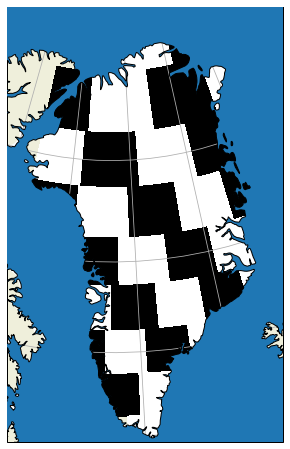

In [19]:
# Dummy Map
XV, YV, dumdata = rebin_data(ddata[:,0], lat, lon, False, lat_bounds=(90, 50), lon_bounds=(290, 360))
#left_i = np.argwhere(XV[0] > 290.)[0,0]
#low_i = np.argwhere(YV.T[0] < 50)[0,0]
#XV = XV[:low_i, left_i:]
#YV = YV[:low_i, left_i:]
#dumdata = dumdata[:low_i, left_i:]

proj = ccrs.LambertConformal(central_latitude=90, central_longitude=310)


f, ax = plt.subplots(figsize=(6, 8), subplot_kw=dict(projection=proj))
cb = ax.pcolor(XV, YV, dumdata, cmap=plt.cm.binary, vmin = 0.0, vmax = 1.0, transform=ccrs.PlateCarree())
ax.set_extent([-65, -25, 59, 85], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m'), zorder=100, edgecolor='k')
ax.gridlines()
f.savefig("./Pictures/dummy_map.png", dpi=300)
plt.show()

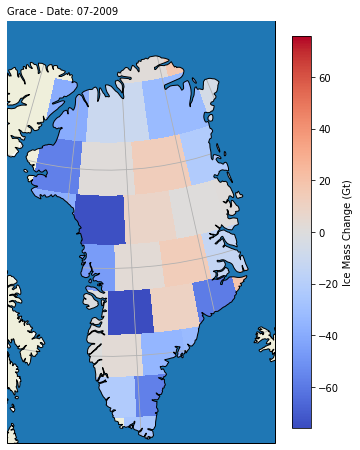

In [20]:
# Verbeterde Plot Routine
_data = resample_mascons(data[0,:,0] * 86400.0, data[:,:,1], t_30days)[1]
XV, YV, fit = rebin_data(_data[:,time_i], lat, lon, lat_bounds=(90, 50), lon_bounds=(290, 360))
proj = ccrs.LambertConformal(central_latitude=90, central_longitude=310)
ctim = datetime(2002, 1, 1) + timedelta(seconds=grace_t[time_i])
#proj = ccrs.PlateCarree(central_longitude=310)


f, ax = plt.subplots(figsize=(6, 8), subplot_kw=dict(projection=proj))
cb = ax.pcolor(XV, YV, fit, cmap=plt.cm.coolwarm, vmin = -np.max(np.abs(fit)), vmax = np.max(np.abs(fit)), transform=ccrs.PlateCarree())
ax.set_extent([-65, -25, 59, 85], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m'), zorder=100, edgecolor='k')
ax.gridlines()
ax.text(0.125, 0.88, "Grace - Date: %s" % ctim.strftime("%m-%Y"), transform=f.transFigure)
cax = f.colorbar(cb, ax=[ax], shrink=0.9)
cax.set_label("Ice Mass Change (Gt)")
f.savefig("./Pictures/data_%s_total.png" % ctim.strftime("%m_%Y"), dpi=300)
plt.show()
del _data

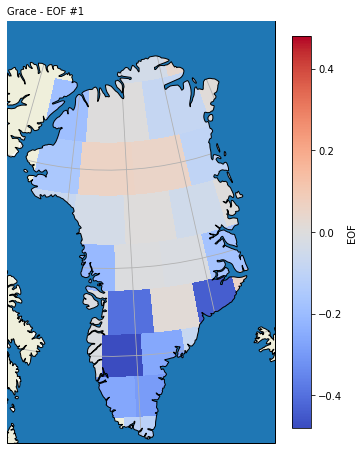

In [21]:
eof_i = 1
XV, YV, eof_fit = rebin_data(evecs[:,eof_i-1], lat, lon, lat_bounds=(90, 50), lon_bounds=(290, 360))

# Verbeterde Plot Routine
proj = ccrs.LambertConformal(central_latitude=90, central_longitude=310)

f, ax = plt.subplots(figsize=(6, 8), subplot_kw=dict(projection=proj))
cb = ax.pcolor(XV, YV, eof_fit, cmap=plt.cm.coolwarm, vmin = -np.max(np.abs(eof_fit)), vmax = np.max(np.abs(eof_fit)), transform=ccrs.PlateCarree())
ax.set_extent([-65, -25, 59, 85], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m'), zorder=100, edgecolor='k')
ax.gridlines()
ax.text(0.125, 0.88, "Grace - EOF #%i" % eof_i, transform=f.transFigure)
cax = f.colorbar(cb, ax=[ax], shrink=0.9)
cax.set_label("EOF")
f.savefig("./Pictures/EOF%i_total.png" % eof_i, dpi=300)
plt.show()

# Regrid Greenland SMB Data

In [22]:
mask = Dataset("./Icemask_Topo_Iceclasses_lon_lat_average_1km.nc", mode='r')
mlon = mask['LON'][:] % 360
mlat = mask['LAT'][:]
mask.close()

lonc = lon[:,:-1] + (lon[:,1:] - lon[:,:-1]) / 2.0
latc = np.array([np.full(lonc.shape[1], l) for l in lat])

In [23]:
create_file = False
import sys

percent = -1.
if create_file:
    data = Dataset("./smb_rec.2002-2017.BN_RACMO2.3p2_FGRN055_GrIS.MM.nc", mode='r')
    T = data['time'][:]
    
    ICE = np.zeros((T.size, lat.size * lonc.shape[1]))
    # Create Index grid
    indices = np.zeros(mlon.shape, dtype=int)
    for yi in range(mlat.shape[0]):
        for xi in range(mlat.shape[1]):
            L = np.sqrt((mlon[yi,xi] - lonc) ** 2 + (mlat[yi,xi] - latc) ** 2)
            indices[yi,xi] = np.nanargmin(L)
        sys.stdout.write("%i/%i\r" % (yi + 1, mlat.shape[0]))
        sys.stdout.flush()
    sys.stdout.write("\n")
        
    # Rebin each original data point
    indices = indices.flatten()
    for i in range(indices.size):    
        ICE[:,indices[i]] += data['SMB_rec'][:,i//mlon.shape[1], i%mlon.shape[1]]
        if (i % 500) == 0:
            sys.stdout.write("\r%i/%i" % (i + 1, indices.size))
            sys.stdout.flush()
    sys.stdout.write("\r%i/%i\n" % (indices.size, indices.size))
    data.close()
    
    # Mean SMB
    ICE_M = np.copy(ICE)
    for i, c in zip(*np.unique(indices, return_counts=True)):
        ICE_M[:,i] /= c
    
    mask = np.full((T.size, lat.size, lonc.shape[1]), np.isnan(lon[:,1:]))
    ICE = ICE.reshape((T.size, lat.size, lonc.shape[1]))
    ICE_M = ICE_M.reshape((T.size, lat.size, lonc.shape[1]))
    
    ICE = np.ma.array(ICE, mask=mask)
    ICE_M = np.ma.array(ICE_M, mask=mask)
    
    data = Dataset("./ICE_mascon.nc", mode='w')
    data.createDimension('time', T.size)
    data.createDimension('y', ICE.shape[1])
    data.createDimension('x', ICE.shape[2])

    data.createVariable("time", "f4", ("time",))
    data.createVariable("SSMB", "f4", ("time", "y", "x",))
    data.createVariable("SMB", "f4", ("time", "y", "x",))

    data['time'][:] = T
    data['SSMB'][:] = ICE
    data['SMB'][:] = ICE_M
    data.close()
    
    SMB = ICE_M
else:
    data = Dataset("./ICE_mascon.nc", mode='r')
    T = data['time'][:]
    SMB = data['SMB'][:]
    data.close()

### To Mascon Area

In [24]:
FSMB = np.flip(SMB, axis=1)#.reshape((T.size, SMB.shape[1] * SMB.shape[2]))
false_i = np.ones(FSMB.shape[1], dtype=int) * FSMB.shape[1]
for i in range(FSMB.shape[1]):
    index = np.argwhere(FSMB[0,i,:].mask)
    false_i[i] = index[0][0] if index.shape[0] != 0 else false_i[i]

mscn_SMB = np.zeros((31, T.size))
for lat_i in range(1, 10):
    if lat_i == 1:
        mscn_SMB[0,:] = FSMB[:,lat_i,false_i[lat_i] - 1] * area_mscn[0]
        mscn_SMB[1,:] = FSMB[:,lat_i,false_i[lat_i] - 2] * area_mscn[1]
    if lat_i == 2:
        mscn_SMB[2,:] = FSMB[:,lat_i,false_i[lat_i] - 1] * area_mscn[2]
        mscn_SMB[3,:] = FSMB[:,lat_i,false_i[lat_i] - 2] * area_mscn[3]
        mscn_SMB[4,:] = FSMB[:,lat_i,false_i[lat_i] - 3] * area_mscn[4]
        mscn_SMB[5,:] = FSMB[:,lat_i,false_i[lat_i] - 4] * area_mscn[5]
    if lat_i == 3:
        mscn_SMB[6,:] = FSMB[:,lat_i,false_i[lat_i] - 2] * area_mscn[6]
        mscn_SMB[7,:] = FSMB[:,lat_i,false_i[lat_i] - 3] * area_mscn[7]
        mscn_SMB[8,:] = FSMB[:,lat_i,false_i[lat_i] - 4] * area_mscn[8]
        mscn_SMB[9,:] = FSMB[:,lat_i,false_i[lat_i] - 5] * area_mscn[9]
    if lat_i == 4:
        mscn_SMB[10,:] = FSMB[:,lat_i,false_i[lat_i] - 2] * area_mscn[10]
        mscn_SMB[11,:] = FSMB[:,lat_i,false_i[lat_i] - 3] * area_mscn[11]
        mscn_SMB[12,:] = FSMB[:,lat_i,false_i[lat_i] - 4] * area_mscn[12]
        mscn_SMB[13,:] = FSMB[:,lat_i,false_i[lat_i] - 5] * area_mscn[13]
        mscn_SMB[14,:] = FSMB[:,lat_i,false_i[lat_i] - 6] * area_mscn[14]
    if lat_i == 5:
        mscn_SMB[15,:] = FSMB[:,lat_i,false_i[lat_i] - 3] * area_mscn[15]
        mscn_SMB[16,:] = FSMB[:,lat_i,false_i[lat_i] - 4] * area_mscn[16]
        mscn_SMB[17,:] = FSMB[:,lat_i,false_i[lat_i] - 5] * area_mscn[17]
        mscn_SMB[18,:] = FSMB[:,lat_i,false_i[lat_i] - 6] * area_mscn[18]
    if lat_i == 6:
        mscn_SMB[19,:] = FSMB[:,lat_i,false_i[lat_i] - 3] * area_mscn[19]
        mscn_SMB[20,:] = FSMB[:,lat_i,false_i[lat_i] - 4] * area_mscn[20]
        mscn_SMB[21,:] = FSMB[:,lat_i,false_i[lat_i] - 5] * area_mscn[21]
        mscn_SMB[22,:] = FSMB[:,lat_i,false_i[lat_i] - 6] * area_mscn[22]
        mscn_SMB[23,:] = FSMB[:,lat_i,false_i[lat_i] - 7] * area_mscn[23]
    if lat_i == 7:
        mscn_SMB[24,:] = FSMB[:,lat_i,false_i[lat_i] - 5] * area_mscn[24]
        mscn_SMB[25,:] = FSMB[:,lat_i,false_i[lat_i] - 6] * area_mscn[25]
        mscn_SMB[26,:] = FSMB[:,lat_i,false_i[lat_i] - 7] * area_mscn[26]
        mscn_SMB[27,:] = FSMB[:,lat_i,false_i[lat_i] - 8] * area_mscn[27]
    if lat_i == 8:
        mscn_SMB[28,:] = FSMB[:,lat_i,false_i[lat_i] - 7] * area_mscn[28]
        mscn_SMB[29,:] = FSMB[:,lat_i,false_i[lat_i] - 8] * area_mscn[29]
    if lat_i == 9:
        mscn_SMB[30,:] = FSMB[:,lat_i,false_i[lat_i] - 8] * area_mscn[30]

mscn_SMB *= 1e-6 # From mm * km^2 to Gt
cmscn_SMB = np.empty(mscn_SMB.shape)
for i in range(mscn_SMB.shape[1]):
    cmscn_SMB[:,i] = np.sum(mscn_SMB[:,:i+1], axis=1)
    
# Resample data from monthly to per 30 day
T_days = np.zeros(T.size)
for ti, tv in enumerate(T):
    T_int = int(np.round(tv))
    T_days[ti] = (datetime(2002 + T_int // 12, T_int % 12 + 1, 1) - datetime(2002, 1, 1)).days

#smb_t, cmscn_SMB = resample_mascons(T_days * 86400, cmscn_SMB, t_30days)   
# Resample SMB data to grace time
cmscn_SMB = np.array([np.interp(grace_t, T_days * 86400, cmscn_SMB[i,:]) for i in range(cmscn_SMB.shape[0])])
smb_t = grace_t

del T_days
del mscn_SMB

In [25]:
# Detrend SMB
SMB_trends = np.zeros((N, 7))
def fit_f(t, a0, a1, a2, a3, a4, b0, b1):
    lintr = a0 + a1 * t + a2 * t * t
    seasonal = a3 * np.cos(2.0 * np.pi / 365.25 * t + b0)
    halfyear = a4 * np.cos(4.0 * np.pi / 365.25 * t + b1)
    return lintr + seasonal + halfyear

for i in range(N):
    popt, pcov = curve_fit(fit_f, smb_t / 86400.0 , cmscn_SMB[i,:])
    SMB_trends[i] = popt

def detrend(data, t, trend):
    return data - trend[0] - trend[1] * t - trend[2] * t ** 2 - trend[3] * np.cos(2.0 * np.pi / 365.25 * t + trend[5]) - trend[4] * np.cos(4.0 * np.pi / 365.25 * t + trend[6])
    
SMB_detrended = np.empty(cmscn_SMB.shape)
for i in range(N):
    SMB_detrended[i] = detrend(cmscn_SMB[i,:], smb_t / 86400.0, SMB_trends[i])
    

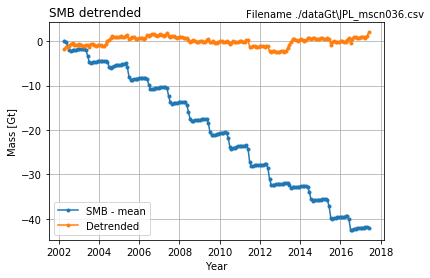

In [26]:
# Extra Plots
data_num = 6

f, ax = plt.subplots()
ax.plot(smb_t / 86400.0 / 365.25 + 2002, cmscn_SMB[data_num-1],'.-',label = 'SMB - mean')
ax.plot(smb_t / 86400.0 / 365.25 + 2002, SMB_detrended[data_num-1],'.-',label = 'Detrended')

ax.set_xlabel('Year')
ax.set_ylabel('Mass [Gt]')
plt.title('SMB detrended', loc='left')
plt.legend()
ax.grid()
ax.text(0.58, 0.9, "Filename %s" % (file_n[data_num-1]), transform=f.transFigure)
f.savefig("./Pictures/timeseries_%i_SMB" % file_ids[data_num-1], dpi=300)
plt.show()

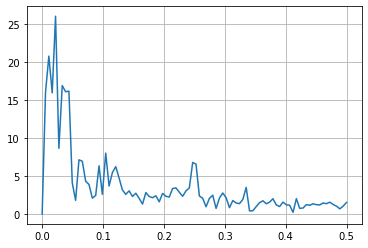

In [27]:
from scipy.fftpack import fft
F = fft(SMB_detrended[0])
H = np.linspace(0.0, 1. / 2., SMB_detrended.shape[1] // 2)
plt.plot(H, np.abs(F[:F.size//2]))
plt.grid()
plt.show()

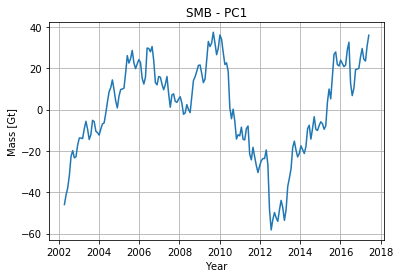

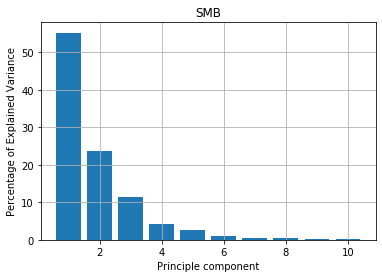

In [28]:
F_SMB = SMB_detrended.T
F_SMBT = np.copy(F_SMB.T)
for i in range(F_SMBT.shape[0]):
    F_SMBT[i] -= F_SMBT[i].mean()
F_SMB = np.copy(F_SMBT.T)
C = np.dot(F_SMBT, F_SMB)
eval_smb, evec_smb = np.linalg.eig(C)
PCA_SMB = np.dot(F_SMB, evec_smb[:])

# Plot PCA
PCA_num = 1

plt.plot(smb_t / 365.25 / 86400 + 2002, PCA_SMB[:,PCA_num-1])
plt.xlabel('Year')
plt.ylabel('Mass [Gt]')
plt.title('SMB - PC' + str(PCA_num))
plt.grid()
plt.savefig("./Pictures/PC%i_SMB.png" % file_ids[PCA_num-1], dpi=300)
plt.show()

pca_max = 10
bars = eval_smb / eval_smb.sum()*100
plt.bar(x=range(1,pca_max+1), height=bars[:pca_max])
plt.title('SMB')
plt.xlabel('Principle component')
plt.ylabel('Percentage of Explained Variance')
plt.grid()
plt.savefig("./Pictures/PC_explained_SMB", dpi=300)
plt.show()

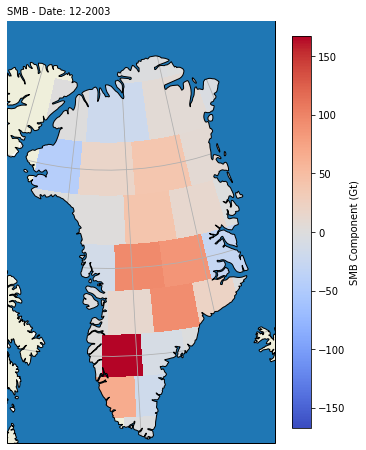

In [29]:
# Verbeterde Plot Routine
time = 20
XV, YV, fit = rebin_data(cmscn_SMB[:,time], lat, lon, lat_bounds=(90, 50), lon_bounds=(290, 360))
proj = ccrs.LambertConformal(central_latitude=90, central_longitude=310)
ctim = datetime(2002, 1, 1) + timedelta(seconds=smb_t[time])
#proj = ccrs.PlateCarree(central_longitude=310)


f, ax = plt.subplots(figsize=(6, 8), subplot_kw=dict(projection=proj))
cb = ax.pcolor(XV, YV, fit, cmap=plt.cm.coolwarm, vmin = -np.max(np.abs(fit)), vmax = np.max(np.abs(fit)), transform=ccrs.PlateCarree())
ax.set_extent([-65, -25, 59, 85], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m'), zorder=100, edgecolor='k')
ax.gridlines()
ax.text(0.125, 0.88, "SMB - Date: %s" % ctim.strftime("%m-%Y"), transform=f.transFigure)
cax = f.colorbar(cb, ax=[ax], shrink=0.9)
cax.set_label("SMB Component (Gt)")
f.savefig("./Pictures/SMB_map_%s.png" % ctim.strftime("%m-%Y"))
plt.show()

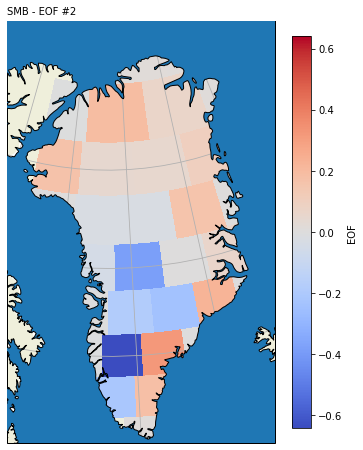

In [30]:
eof_i = 2
XV, YV, eof_fit = rebin_data(evec_smb[:,eof_i-1], lat, lon, lat_bounds=(90, 50), lon_bounds=(290, 360))

# Verbeterde Plot Routine
proj = ccrs.LambertConformal(central_latitude=90, central_longitude=310)

f, ax = plt.subplots(figsize=(6, 8), subplot_kw=dict(projection=proj))
cb = ax.pcolor(XV, YV, eof_fit, cmap=plt.cm.coolwarm, vmin = -np.max(np.abs(eof_fit)), vmax = np.max(np.abs(eof_fit)), transform=ccrs.PlateCarree())
ax.set_extent([-65, -25, 59, 85], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m'), zorder=100, edgecolor='k')
ax.gridlines()
ax.text(0.125, 0.88, "SMB - EOF #%i" % eof_i, transform=f.transFigure)
cax = f.colorbar(cb, ax=[ax], shrink=0.9)
cax.set_label("EOF")
f.savefig("./Pictures/EOF%i_SMB.png" % eof_i, dpi=300)
plt.show()

# Determining Discharge

In [31]:
# To get the discharge from grace and SMB we need to map SMB entries to grace entries
# We do this by way of a linear fit of SMB to grace; this is the most practical as
# grace's fit has fewer entries
dis_detrended = ddata - SMB_detrended
dis_t = grace_t


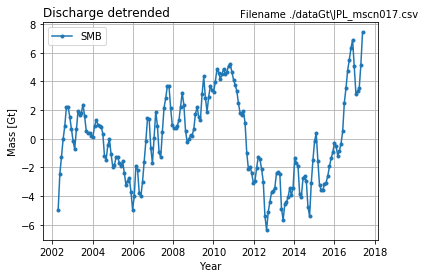

In [32]:
# Extra Plots
data_num = 1

f, ax = plt.subplots()
ax.plot(dis_t / 365.25 / 86400 + 2002, dis_detrended[data_num-1],'.-',label = 'SMB')
ax.set_xlabel('Year')
ax.set_ylabel('Mass [Gt]')
plt.title('Discharge detrended', loc='left')
plt.legend()
ax.grid()
ax.text(0.58, 0.9, "Filename %s" % (file_n[data_num-1]), transform=f.transFigure)
f.savefig("./Pictures/timeseries_%i_discharge" % file_ids[data_num-1], dpi=300)
plt.show()

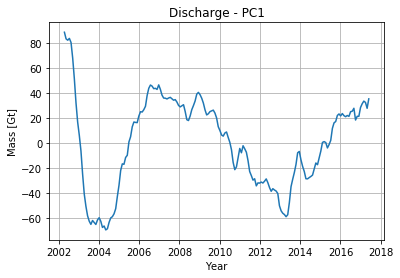

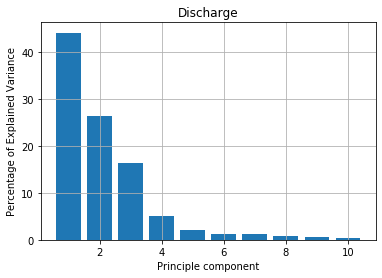

In [33]:
# PCA Analysis

R = dis_detrended.T
RT = np.copy(R.T)
for i in range(RT.shape[0]):
    RT[i] -= RT[i].mean()
R = np.copy(RT.T)
C = np.dot(RT, R)
evals_d, evecs_d = np.linalg.eig(C)
PCA_d = np.dot(R, evecs_d[:])

# Plot PCA
PCA_num = 1

plt.plot(dis_t / 365.25 / 86400. + 2002, PCA_d[:,PCA_num-1])
plt.xlabel('Year')
plt.ylabel('Mass [Gt]')
plt.title('Discharge - PC' + str(PCA_num))
plt.grid()
plt.savefig("./Pictures/PC%i_discharge.png" % PCA_num, dpi=300)
plt.show()

pca_max = 10
bars = evals_d / evals_d.sum()*100
plt.bar(x=range(1,pca_max+1), height=bars[:pca_max])
plt.title('Discharge')
plt.xlabel('Principle component')
plt.ylabel('Percentage of Explained Variance')
plt.grid()
plt.savefig("./Pictures/PC_explained_discharge", dpi=300)
plt.show()

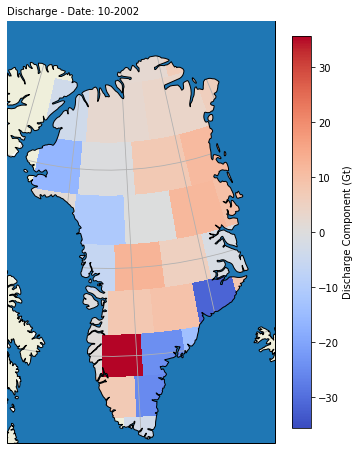

In [34]:
# Verbeterde Plot Routine
time = 6
XV, YV, fit = rebin_data(dis_detrended[:,time], lat, lon, lat_bounds=(90, 50), lon_bounds=(290, 360))
proj = ccrs.LambertConformal(central_latitude=90, central_longitude=310)
ctim = datetime(2002, 1, 1) + timedelta(seconds=dis_t[time])
#proj = ccrs.PlateCarree(central_longitude=310)


f, ax = plt.subplots(figsize=(6, 8), subplot_kw=dict(projection=proj))
cb = ax.pcolor(XV, YV, fit, cmap=plt.cm.coolwarm, vmin = -np.max(np.abs(fit)), vmax = np.max(np.abs(fit)), transform=ccrs.PlateCarree())
ax.set_extent([-65, -25, 59, 85], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m'), zorder=100, edgecolor='k')
ax.gridlines()
ax.text(0.125, 0.88, "Discharge - Date: %s" % ctim.strftime("%m-%Y"), transform=f.transFigure)
cax = f.colorbar(cb, ax=[ax], shrink=0.9)
cax.set_label("Discharge Component (Gt)")
f.savefig("./Pictures/discharge_map_%s.png" % ctim.strftime("%m-%Y"))

plt.show()

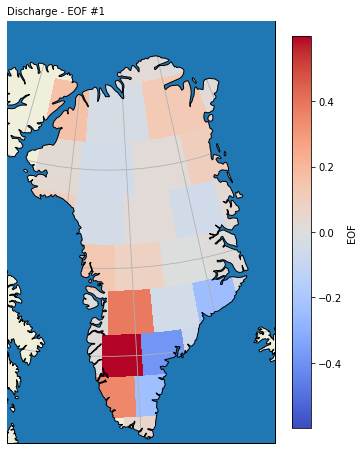

In [35]:
eof_i = 1
XV, YV, eof_fit = rebin_data(evecs_d[:,eof_i-1], lat, lon, lat_bounds=(90, 50), lon_bounds=(290, 360))

# Verbeterde Plot Routine
proj = ccrs.LambertConformal(central_latitude=90, central_longitude=310)

f, ax = plt.subplots(figsize=(6, 8), subplot_kw=dict(projection=proj))
cb = ax.pcolor(XV, YV, eof_fit, cmap=plt.cm.coolwarm, vmin = -np.max(np.abs(eof_fit)), vmax = np.max(np.abs(eof_fit)), transform=ccrs.PlateCarree())
ax.set_extent([-65, -25, 59, 85], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m'), zorder=100, edgecolor='k')
ax.gridlines()
ax.text(0.125, 0.88, "Discharge - EOF #%i" % eof_i, transform=f.transFigure)
cax = f.colorbar(cb, ax=[ax], shrink=0.9)
cax.set_label("EOF")
f.savefig("./Pictures/EOF%i_runoff.png" % eof_i, dpi=300)

plt.show()

# Correlating Indices

In [50]:
nao = Dataset("./inao.nc", mode='r')
nao_d = nao['NAO'][:]
nao_t = np.zeros(nao['time'][:].size)
for ti, tv in enumerate(nao['time'][:]):
    T_month = int(np.round(tv))
    nao_t[ti] = (datetime(1821 + T_month // 12, T_month % 12 + 1, 15) - datetime(2002, 1, 1)).days
    
nao_t *= 86400 # To Seconds
nao.close()

snao = Dataset("./isnao_ncepncar.nc", mode='r')
snao_d = snao['SNAO'][:]
snao_t = np.zeros(snao['time'][:].size)
for ti, tv in enumerate(snao['time'][:]):
    T_month = int(np.round(tv))
    snao_t[ti] = (datetime(1948 + T_month // 12, T_month % 12 + 1, 15) - datetime(2002, 1, 1)).days
    
snao_t *= 86400.0
snao.close()

ao = Dataset("./isnao_ncepncar.nc", mode='r')
ao_d = ao['SNAO'][:]
ao_t = np.zeros(ao['time'][:].size)
for ti, tv in enumerate(ao['time'][:]):
    T_month = int(np.round(tv))
    ao_t[ti] = (datetime(1950 + T_month // 12, T_month % 12 + 1, 15) - datetime(2002, 1, 1)).days
    
ao_t *= 86400.0
ao.close()

enso = Dataset("./iersst_nino12a.nc", mode='r')
enso_d = enso['Nino12'][:]
enso_t = np.zeros(enso['time'][:].size)
for ti, tv in enumerate(enso['time'][:]):
    T_month = int(np.round(tv))
    enso_t[ti] = (datetime(1854 + T_month // 12, T_month % 12 + 1, 15) - datetime(2002, 1, 1)).days
    
enso_t *= 86400.0
enso.close()

amo = Dataset("./iamo_hadsst.nc", mode='r')
amo_d = amo['AMO'][:]
amo_t = np.zeros(amo['time'][:].size)
for ti, tv in enumerate(amo['time'][:]):
    T_month = int(np.round(tv))
    amo_t[ti] = (datetime(1850 + T_month // 12, T_month % 12 + 1, 15) - datetime(2002, 1, 1)).days
amo_t *= 86400.0
amo.close()

grb_d = np.genfromtxt("./grnland_blck.txt", delimiter='\t')
gbd_temp = grb_d[:,0]
grb_d = grb_d[:,1:-1].flatten()
grb_t = np.empty(grb_d.shape)

for ti in range(grb_t.size):
    tv = gbd_temp[int(ti // 12)]
    grb_t[ti] = (tv - 2002) * 12.0 + (ti % 12)

grb_t *= 365.25 * 86400.0
del gbd_temp


[-6.57000000e+02 -6.55966667e+02 -6.55000000e+02 -6.53966667e+02
 -6.52966667e+02 -6.51933333e+02 -6.50933333e+02 -6.49900000e+02
 -6.48866667e+02 -6.47866667e+02 -6.46833333e+02 -6.45833333e+02
 -6.44800000e+02 -6.43766667e+02 -6.42833333e+02 -6.41800000e+02
 -6.40800000e+02 -6.39766667e+02 -6.38766667e+02 -6.37733333e+02
 -6.36700000e+02 -6.35700000e+02 -6.34666667e+02 -6.33666667e+02
 -6.32633333e+02 -6.31600000e+02 -6.30666667e+02 -6.29633333e+02
 -6.28633333e+02 -6.27600000e+02 -6.26600000e+02 -6.25566667e+02
 -6.24533333e+02 -6.23533333e+02 -6.22500000e+02 -6.21500000e+02
 -6.20466667e+02 -6.19433333e+02 -6.18500000e+02 -6.17466667e+02
 -6.16466667e+02 -6.15433333e+02 -6.14433333e+02 -6.13400000e+02
 -6.12366667e+02 -6.11366667e+02 -6.10333333e+02 -6.09333333e+02
 -6.08300000e+02 -6.07266667e+02 -6.06300000e+02 -6.05266667e+02
 -6.04266667e+02 -6.03233333e+02 -6.02233333e+02 -6.01200000e+02
 -6.00166667e+02 -5.99166667e+02 -5.98133333e+02 -5.97133333e+02
 -5.96100000e+02 -5.95066

In [37]:
def timeseries_corr(t, d, index_x, index_y):
    assert len(t) == len(d), "Invalid time series length"
    assert len(index_x) == len(index_y), "Index time series dimensions do not match"
    
    index_m = np.interp(t, index_x, index_y)
    return np.corrcoef(d, index_m)[0,1]

def PCA_correlate(PCA_x, PCA_y, index_x, index_y):
    assert PCA_x.size == PCA_y.shape[0], "Invalid time series for PCA component set"
    assert len(index_x) == len(index_y), "Index time series dimensions do not match"
    
    index_m = np.interp(PCA_x, index_x, index_y)
    corr = np.empty(N)
    for i, pca_v in enumerate(PCA_y.T):
        corr[i] = np.corrcoef(pca_v, index_m)[0,1]
        
    return corr

def plot_PCA_correlate(ax, PCA_x, PCA_y, index_x, index_y, **kwargs):
    corr = PCA_correlate(PCA_x, PCA_y, index_x, index_y)
    ax.grid(True)
    ax.bar(np.arange(corr.size//2) + 1, corr[:corr.size//2])
    ax.set_xlabel("PCA Component")
    ax.set_ylim(-0.6, 0.6)
    if 'title' in kwargs:
        ax.set_title(kwargs['title'])
    return corr


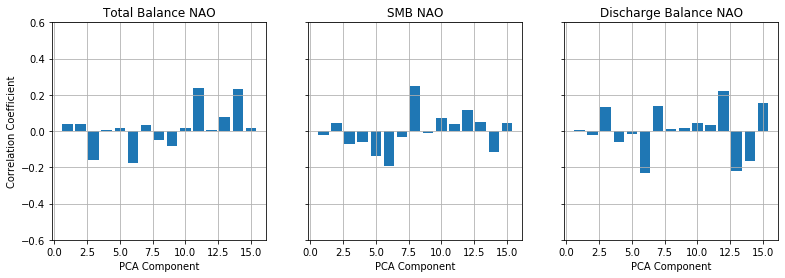

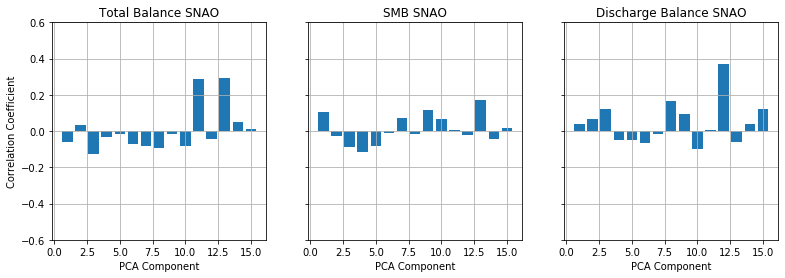

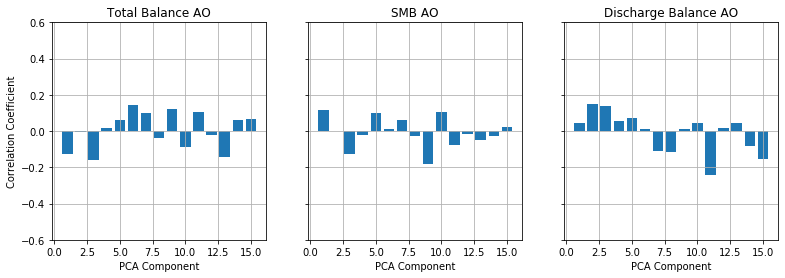

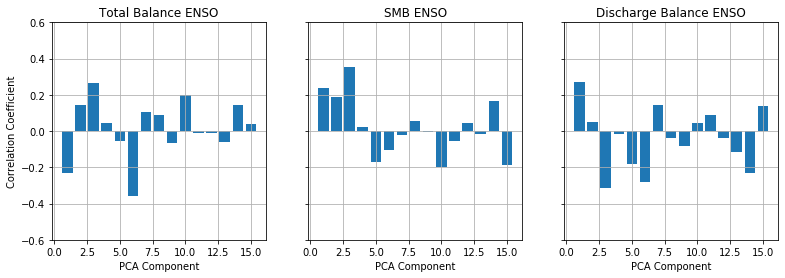

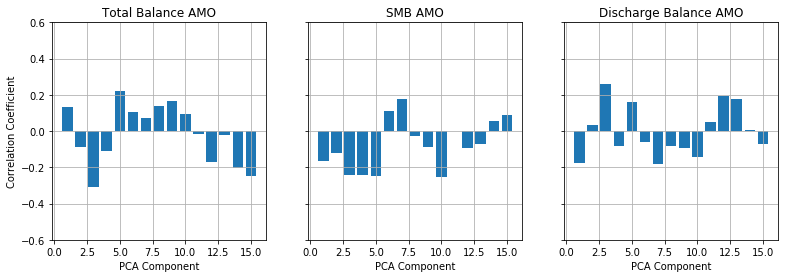

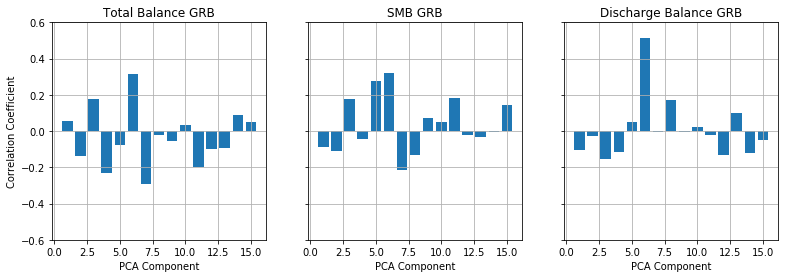

In [38]:
f, ax = plt.subplots(1, 3, sharey=True, figsize=(13, 4))
plot_PCA_correlate(ax[0], grace_t, PCA, nao_t, nao_d, title='Total Balance NAO')
plot_PCA_correlate(ax[1], smb_t, PCA_SMB, nao_t, nao_d, title='SMB NAO')
plot_PCA_correlate(ax[2], dis_t, PCA_d, nao_t, nao_d, title='Discharge Balance NAO')
ax[0].set_ylabel("Correlation Coefficient")
plt.show()

f, ax = plt.subplots(1, 3, sharey=True, figsize=(13, 4))
plot_PCA_correlate(ax[0], grace_t, PCA, snao_t, snao_d, title='Total Balance SNAO')
plot_PCA_correlate(ax[1], smb_t, PCA_SMB, snao_t, snao_d, title='SMB SNAO')
plot_PCA_correlate(ax[2], dis_t, PCA_d, snao_t, snao_d, title='Discharge Balance SNAO')
ax[0].set_ylabel("Correlation Coefficient")
plt.show()

f, ax = plt.subplots(1, 3, sharey=True, figsize=(13, 4))
plot_PCA_correlate(ax[0], grace_t, PCA, ao_t, ao_d, title='Total Balance AO')
plot_PCA_correlate(ax[1], smb_t, PCA_SMB, ao_t, ao_d, title='SMB AO')
plot_PCA_correlate(ax[2], dis_t, PCA_d, ao_t, ao_d, title='Discharge Balance AO')
ax[0].set_ylabel("Correlation Coefficient")
plt.show()

f, ax = plt.subplots(1, 3, sharey=True, figsize=(13, 4))
plot_PCA_correlate(ax[0], grace_t, PCA, enso_t, enso_d, title='Total Balance ENSO')
plot_PCA_correlate(ax[1], smb_t, PCA_SMB, enso_t, enso_d, title='SMB ENSO')
plot_PCA_correlate(ax[2], dis_t, PCA_d, enso_t, enso_d, title='Discharge Balance ENSO')
ax[0].set_ylabel("Correlation Coefficient")
plt.show()

f, ax = plt.subplots(1, 3, sharey=True, figsize=(13, 4))
plot_PCA_correlate(ax[0], grace_t, PCA, amo_t, amo_d, title='Total Balance AMO')
plot_PCA_correlate(ax[1], smb_t, PCA_SMB, amo_t, amo_d, title='SMB AMO')
plot_PCA_correlate(ax[2], dis_t, PCA_d, amo_t, amo_d, title='Discharge Balance AMO')
ax[0].set_ylabel("Correlation Coefficient")
plt.show()

f, ax = plt.subplots(1, 3, sharey=True, figsize=(13, 4))
plot_PCA_correlate(ax[0], grace_t, PCA, grb_t, grb_d, title='Total Balance GRB')
plot_PCA_correlate(ax[1], smb_t, PCA_SMB, grb_t, grb_d, title='SMB GRB')
plot_PCA_correlate(ax[2], dis_t, PCA_d, grb_t, grb_d, title='Discharge Balance GRB')
ax[0].set_ylabel("Correlation Coefficient")
plt.show()

In [39]:
PCA_correlate(dis_t, PCA_d, grb_t, grb_d).max()

0.515755753416846

### Lagged Cross-correlation Coefficients

In [40]:
def crosscorrelate(x, y):
    """Calculate the cross correlation of x with y through Fourier analyis
    see http://mathworld.wolfram.com/Cross-CorrelationTheorem.html
    """
    assert len(x) == len(y), "cross-correlation module requires equal length array input"
    N = len(x)
    kv = np.arange(N)
    
    # x fourier transform
    Fx_ak = np.r_[np.sum(x), [np.dot(x, np.cos(2.0 * np.pi * k * kv / N)) for k in kv[1:]]]
    Fx_bk = np.r_[0.0, [np.dot(x, -np.sin(2.0 * np.pi * k * kv / N)) for k in kv[1:]]]
    
    # y fourier transform
    Fy_ak = np.r_[np.sum(y), [np.dot(y, np.cos(2.0 * np.pi * k * kv / N)) for k in kv[1:]]]
    Fy_bk = np.r_[0.0, [np.dot(y, -np.sin(2.0 * np.pi * k * kv / N)) for k in kv[1:]]]
    
    # Calculate conj(Fx) * Fy
    FXY_ak = Fx_ak * Fy_ak + Fx_bk * Fy_bk
    FXY_bk = Fx_ak * Fy_bk - Fx_bk * Fy_ak
    
    # Reverse fourier transform
    C = np.zeros(N)
    C[0] = np.sum(FXY_ak)
    for n in range(1, N):
        C[n] += np.dot(FXY_ak, np.cos(2.0 * np.pi * n * kv / N))
        C[n] += np.dot(FXY_bk, np.sin(2.0 * np.pi * n * kv / N))
    C /= N
    
    normfac = np.sqrt(np.correlate(x,x, mode='same')[len(x)//2] * np.correlate(y,y, mode='same')[len(y)//2])    
    return C / normfac

# cross correlation function for mascons
def PCA_crosscorrelate(PCA_x, PCA_y, index_x, index_y):
    assert PCA_x.size == PCA_y.shape[0], "Invalid time series for PCA component set"
    assert len(index_x) == len(index_y), "Index time series dimensions do not match"
    
    index_m = np.interp(PCA_x, index_x, index_y)
    ccorr = np.empty((PCA_y.shape[1], PCA_x.size))
    for mi in range(PCA_y.shape[1]):
        ccorr[mi] = crosscorrelate(PCA_y[:,mi], index_m)
    return ccorr


def plot_PCA_crosscorrelate(ax, PCA_x, PCA_y, index_x, index_y, weights=None, mode='singular', **kwargs):
    corv = PCA_crosscorrelate(PCA_x, PCA_y, index_x, index_y)
    
    lag_m = np.inf
    if weights is None:
        weights = np.ones(PCA_y.shape[1])
    if "lag_max" in kwargs:
        lag_m = kwargs["lag_max"]
      
    if mode == 'singular':
        imax, maxv = 0, 0.0
        for lag, c in enumerate(corv.T):
            if np.max(np.abs(c * weights)) > maxv:
                imax = lag
                maxv = np.max(np.abs(c * weights)) 
        corv = corv[:,min(imax,lag_m)]
    elif mode == 'total':
        imax, maxv = 0, 0.0
        for lag, c in enumerate(corv.T):
            wval = np.dot(np.abs(c), weights)
            if wval > maxv:
                imax = lag
                maxv = wval
        corv = corv[:,min(imax,lag_m)]
    else:
        raise ValueError("Invalid mode " + str(mode) + " passed.")
        
        
        
    
    ax.grid(True)
    ax.set_xlabel("PCA Component")
    ax.set_ylim(-1.0, 1.0)
    ax.bar(np.arange(PCA.shape[1] // 2) + 1, corv[:corv.size//2])
    ax.text(0.05, 0.91, "lag = $%.0f$ months" % ((PCA_x[min(imax,lag_m)] - PCA_x[0]) / 86400.0 / 30.0))
    if 'title' in kwargs:
        ax.set_title(kwargs['title'])

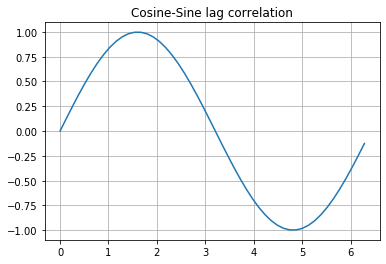

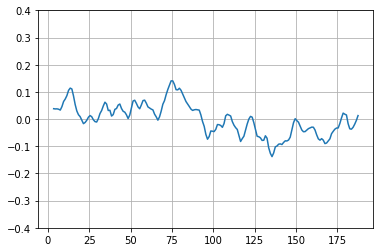

In [41]:
# Test Section
tt = np.linspace(0, 2.0 * np.pi, 50)
xt = np.cos(tt)
yt = np.sin(tt)
plt.plot(tt, crosscorrelate(yt, xt))
plt.grid()
plt.title("Cosine-Sine lag correlation")
plt.show()
del tt,xt,yt

plt.plot(grace_t / 86400 / 30, PCA_crosscorrelate(dis_t, PCA_d, snao_t, snao_d)[0])
plt.ylim(-.4, .4)
plt.grid()
plt.show()

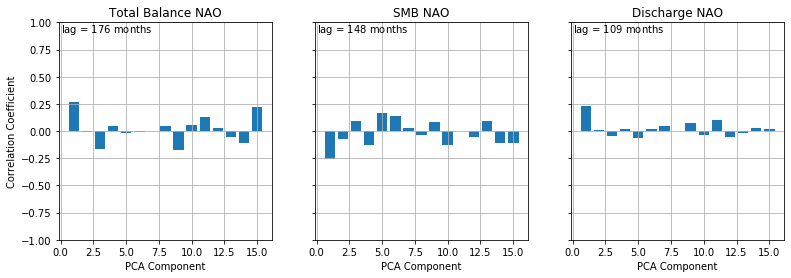

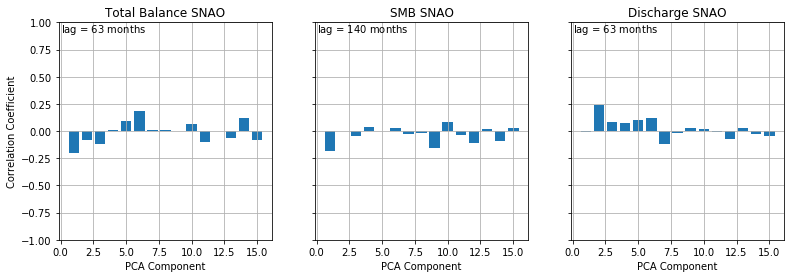

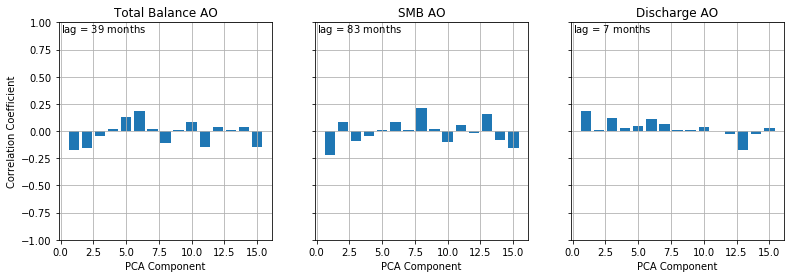

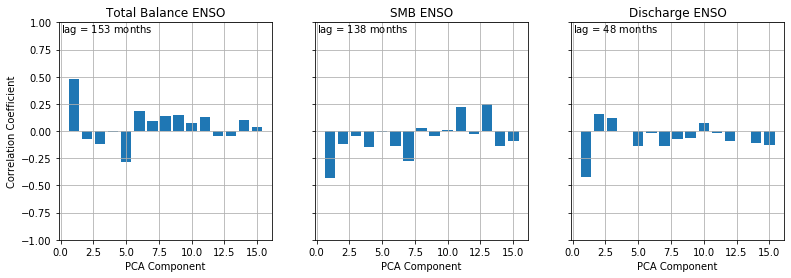

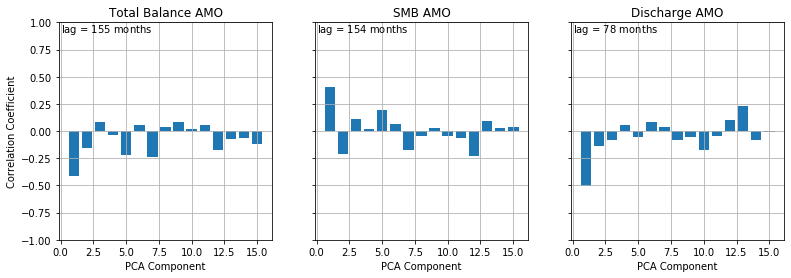

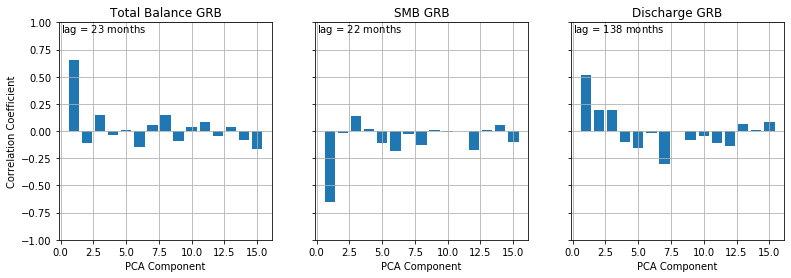

In [42]:
# Plot
f, ax = plt.subplots(1, 3, sharey=True, figsize=(13, 4))
plot_PCA_crosscorrelate(ax[0], grace_t, PCA, nao_t, nao_d, title='Total Balance NAO', weights=evals/evals.sum())#, lag_max=48)#, mode='total')
plot_PCA_crosscorrelate(ax[1], smb_t, PCA_SMB, nao_t, nao_d, title='SMB NAO', weights=eval_smb/eval_smb.sum())#, lag_max=48)#, mode='total')
plot_PCA_crosscorrelate(ax[2], dis_t, PCA_d, nao_t, nao_d, title='Discharge NAO', weights=evals_d/evals_d.sum())#, lag_max=48)#, mode='total')
ax[0].set_ylabel("Correlation Coefficient")
plt.show()

# Plot
f, ax = plt.subplots(1, 3, sharey=True, figsize=(13, 4))
plot_PCA_crosscorrelate(ax[0], grace_t, PCA, snao_t, snao_d, title='Total Balance SNAO', weights=evals/evals.sum())#, lag_max=48)
plot_PCA_crosscorrelate(ax[1], smb_t, PCA_SMB, snao_t, snao_d, title='SMB SNAO', weights=eval_smb/eval_smb.sum())#, lag_max=48)
plot_PCA_crosscorrelate(ax[2], dis_t, PCA_d, snao_t, snao_d, title='Discharge SNAO', weights=evals_d/evals_d.sum())#, lag_max=48)
ax[0].set_ylabel("Correlation Coefficient")
plt.show()

# Plot
f, ax = plt.subplots(1, 3, sharey=True, figsize=(13, 4))
plot_PCA_crosscorrelate(ax[0], grace_t, PCA, ao_t, ao_d, title='Total Balance AO', weights=evals/evals.sum())#, lag_max=48)
plot_PCA_crosscorrelate(ax[1], smb_t, PCA_SMB, ao_t, ao_d, title='SMB AO', weights=eval_smb/eval_smb.sum())#, lag_max=48)
plot_PCA_crosscorrelate(ax[2], dis_t, PCA_d, ao_t, ao_d, title='Discharge AO', weights=evals_d/evals_d.sum())#, lag_max=48)
ax[0].set_ylabel("Correlation Coefficient")
plt.show()

# Plot
f, ax = plt.subplots(1, 3, sharey=True, figsize=(13, 4))
plot_PCA_crosscorrelate(ax[0], grace_t, PCA, enso_t, enso_d, title='Total Balance ENSO', weights=evals/evals.sum())#, lag_max=48)
plot_PCA_crosscorrelate(ax[1], smb_t, PCA_SMB, enso_t, enso_d, title='SMB ENSO', weights=eval_smb/eval_smb.sum())#, lag_max=48)
plot_PCA_crosscorrelate(ax[2], dis_t, PCA_d, enso_t, enso_d, title='Discharge ENSO', weights=evals_d/evals_d.sum())#, lag_max=48)
ax[0].set_ylabel("Correlation Coefficient")
plt.show()

# Plot
f, ax = plt.subplots(1, 3, sharey=True, figsize=(13, 4))
plot_PCA_crosscorrelate(ax[0], grace_t, PCA, amo_t, amo_d, title='Total Balance AMO', weights=evals/evals.sum())#, lag_max=48)
plot_PCA_crosscorrelate(ax[1], smb_t, PCA_SMB, amo_t, amo_d, title='SMB AMO', weights=eval_smb/eval_smb.sum())#, lag_max=48)
plot_PCA_crosscorrelate(ax[2], dis_t, PCA_d, amo_t, amo_d, title='Discharge AMO', weights=evals_d/evals_d.sum())#, lag_max=48)
ax[0].set_ylabel("Correlation Coefficient")
plt.show()

# Plot
f, ax = plt.subplots(1, 3, sharey=True, figsize=(13, 4))
plot_PCA_crosscorrelate(ax[0], grace_t, PCA, grb_t, grb_d, title='Total Balance GRB', weights=evals/evals.sum())#, lag_max=48)
plot_PCA_crosscorrelate(ax[1], smb_t, PCA_SMB, grb_t, grb_d, title='SMB GRB', weights=eval_smb/eval_smb.sum())#, lag_max=48)
plot_PCA_crosscorrelate(ax[2], dis_t, PCA_d, grb_t, grb_d, title='Discharge GRB', weights=evals_d/evals_d.sum())#, lag_max=48)
ax[0].set_ylabel("Correlation Coefficient")
plt.show()

### Total Greenland Correlations

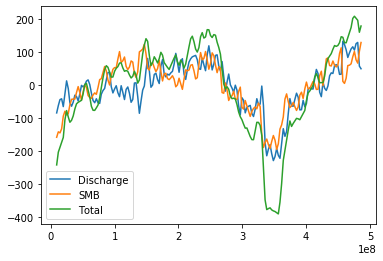

[[-0.00392165  0.12516718  0.10819048  0.22186644 -0.09986045 -0.1377874 ]
 [-0.04678054 -0.02386209  0.10750652  0.29299521 -0.16388847 -0.11145577]
 [-0.02773799  0.05431844  0.1171424   0.27995713 -0.14354375 -0.13524084]]


In [43]:
SMB_dt = SMB_detrended.sum(axis=0) 
dis_dt = dis_detrended.sum(axis=0)
tot_dt = SMB_dt + dis_dt

plt.plot(grace_t, dis_dt)
plt.plot(grace_t, SMB_dt)
plt.plot(grace_t, tot_dt)
plt.legend(('Discharge', 'SMB', 'Total'))
plt.show()

corr_m = np.zeros((3, 6))
indd_m = ([nao_t, snao_t, ao_t, enso_t, amo_t, grb_t], [nao_d, snao_d, ao_d, enso_d, amo_d, grb_d])
for i, sb in enumerate((SMB_dt, dis_dt, tot_dt)):
    corr_m[i] = [timeseries_corr(grace_t, sb, indd_m[0][n], indd_m[1][n]) for n in range(6)]
print(corr_m)

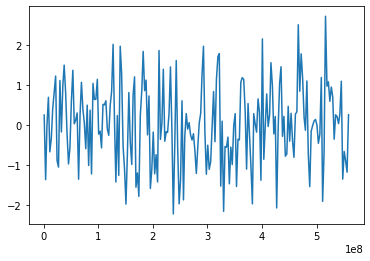

In [49]:
inds = np.argwhere(snao_t >= 0.0)

plt.plot(snao_t[inds], snao_d[inds])

In [ ]:
sa